In [1]:
import os
import matplotlib
from math import *
from pandas import *
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


%matplotlib inline
# sns.set(style="darkgrid")

In [2]:
pcap_file ="./lab-pc/trace3/trace3.raw"
csv_file = "./lab-pc/trace3/trace3.csv"
if not os.path.exists(csv_file):
    tshark_cmd = 'tshark -T fields -e _ws.col.No. -e _ws.col.Time -e _ws.col.Source -e _ws.col.Destination -e _ws.col.tls_len -e _ws.col.Info -E header=y -E separator="\t" -E quote=d -E occurrence=f -r {} > {}'.format(pcap_file, csv_file)  
    os.system(tshark_cmd);

In [3]:
pcap_main = read_csv(csv_file,sep="\t", index_col=None, encoding='utf-8')
pcap_main.rename(index=str, columns={"_ws.col.No.": "No", "_ws.col.Time": "Time","_ws.col.Source": "Source","_ws.col.Destination": "Destination", "_ws.col.tls_len": "tls_len","_ws.col.Info": "Info"}, inplace=True);
pcap_main.head()

,No,Time,Source,Destination,tls_len,Info
0,1,0.000000,SuperMic_dc:ba:c7,Broadcast,NaN,Who has 192.168.1.163? Tell 192.168.1.248
1,2,0.186749,192.168.1.238,10.6.0.11,NaN,Standard query 0x46e2 A www.netflix.com
2,3,0.188078,192.168.1.238,10.6.0.11,NaN,Standard query 0xc87e A clientservices.googlea...
3,4,0.212823,192.168.1.238,10.6.0.11,NaN,Standard query 0xdc35 A mtalk.google.com
4,5,0.213351,192.168.1.238,10.6.0.11,NaN,Standard query 0xeef7 A www.googleapis.com


In [ ]:
local_ip = pcap_main['Destination'].value_counts().idxmax()
nf_ip = pcap_main['Source'].value_counts().idxmax()

In [5]:
# Create new data frame to plot the get requests
pcap_get = pcap_main[pcap_main['Destination']== nf_ip]

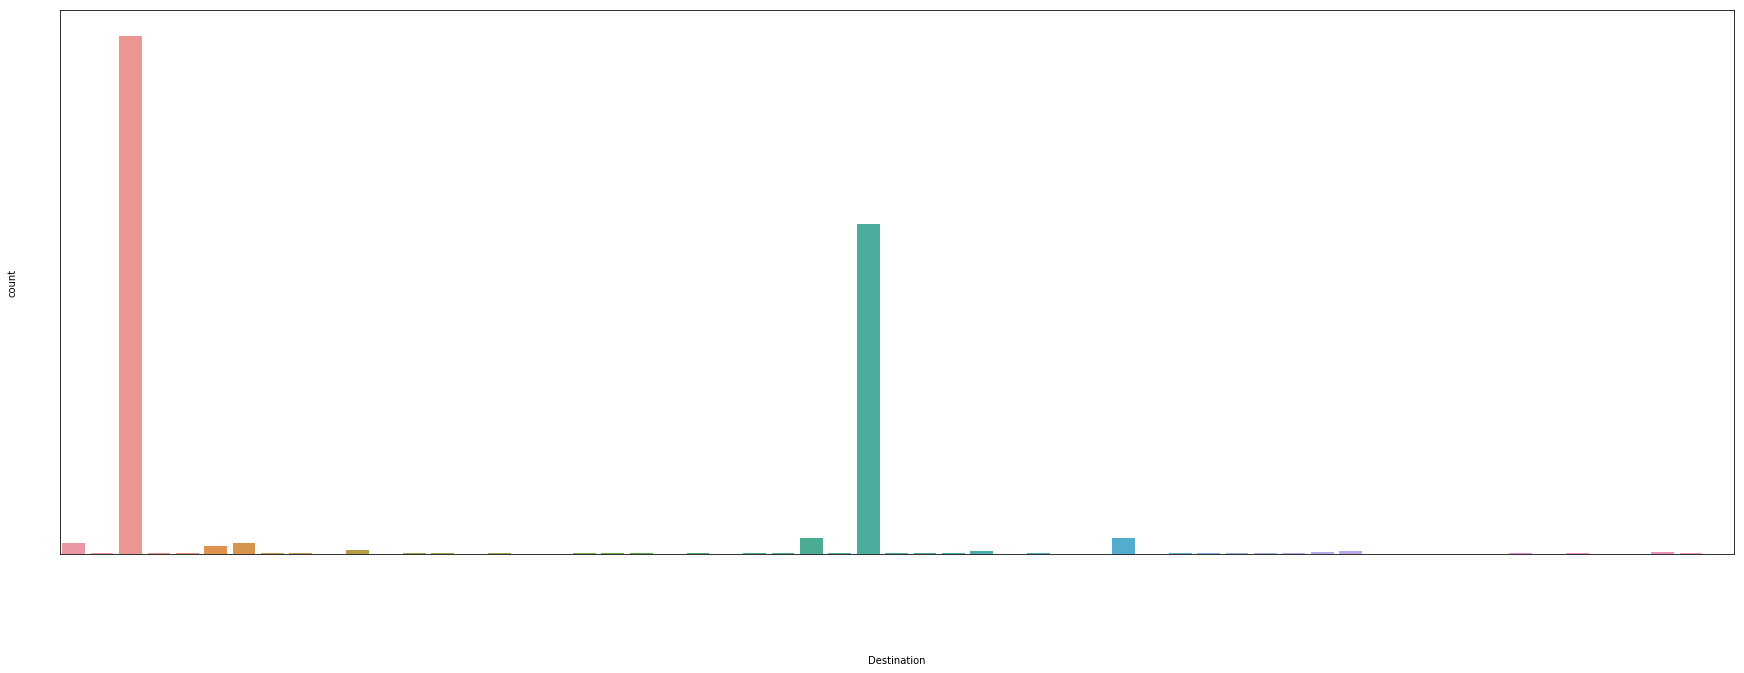

In [6]:
plt.figure(figsize=(30 ,10))
ax = sns.countplot(x="Destination", data=pcap_main)
plt.xticks(rotation=90)
plt.rcParams['xtick.labelsize'] = 15
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')

In [7]:
# countng number of packets arived at a particular time (sec)
pkt_cnt = [0] # number of Packets at i'th sec 
d_time = []  # list of time 
start_time = floor(pcap_get.iloc[0,1]) # start time of the first packet in the list

i = 0
d_time.append(start_time)

for _,packet in pcap_get.iterrows():
    curr_time = floor(packet.Time)
    if curr_time > start_time:
        i += 1
        pkt_cnt.append(0)
        d_time.append(curr_time)
        start_time = curr_time
    pkt_cnt[i]+= 1
    

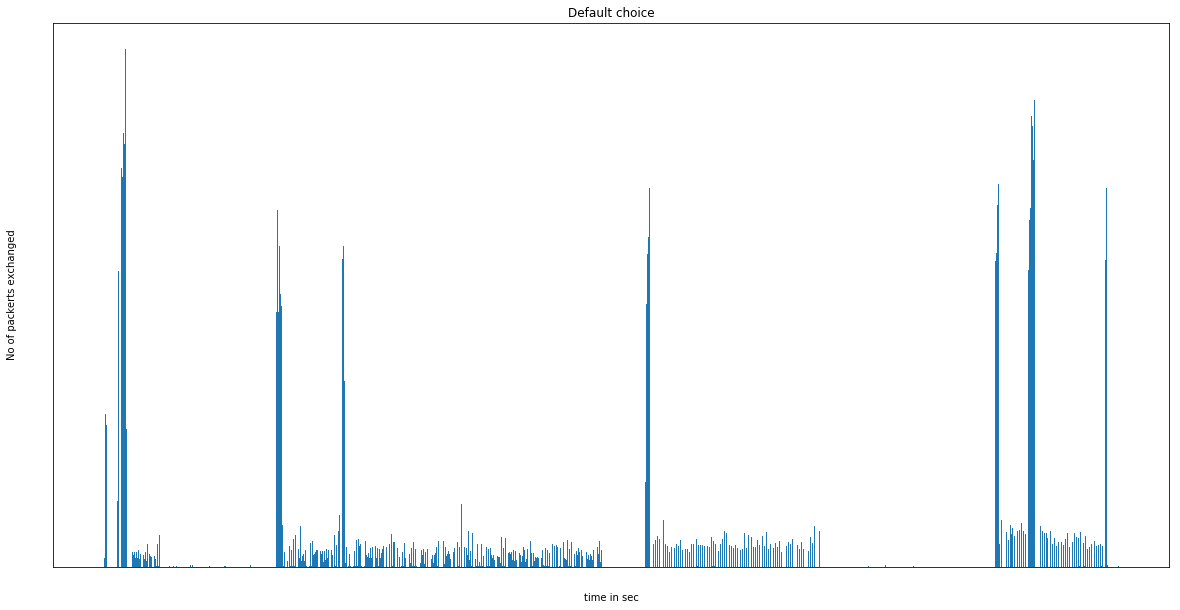

In [8]:
# plotting number of packets vs time
plt.figure(figsize=(20 ,10)) 
plt.bar(d_time, pkt_cnt)
plt.ylabel('No of packerts exchanged')
plt.xlabel('time in sec')
plt.title("Default choice")
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')
plt.show()

In [9]:
# Finding peaks
delta = 0
th = 350
peaks =[] # May contain duplicates
for i in range(1,len(pkt_cnt)):
    delta = pkt_cnt[i]-pkt_cnt[i-1]
    if delta > th:
        startTime = d_time[i]
    elif delta < -th:
        endTime = d_time[i]
        peaks.append([startTime, endTime])
print(peaks)

[[18, 24], [160, 166], [219, 223], [497, 501], [497, 503], [812, 818], [844, 853], [913, 916]]


In [10]:
# range with no duplicates
f_peaks = [] # Final peaks with hopefuly no duplicates
for i in range(len(peaks)-1):
    if peaks[i][0] != peaks[i+1][0]:
        f_peaks.append(peaks[i])
f_peaks.append(peaks[i+1])

print(f_peaks)

[[18, 24], [160, 166], [219, 223], [497, 503], [812, 818], [844, 853], [913, 916]]


In [11]:
# filling all unknown ssl.record.length with -1
pcap_main.fillna(-1, inplace=True)
pcap_main.head()

,No,Time,Source,Destination,tls_len,Info
0,1,0.000000,SuperMic_dc:ba:c7,Broadcast,-1,Who has 192.168.1.163? Tell 192.168.1.248
1,2,0.186749,192.168.1.238,10.6.0.11,-1,Standard query 0x46e2 A www.netflix.com
2,3,0.188078,192.168.1.238,10.6.0.11,-1,Standard query 0xc87e A clientservices.googlea...
3,4,0.212823,192.168.1.238,10.6.0.11,-1,Standard query 0xdc35 A mtalk.google.com
4,5,0.213351,192.168.1.238,10.6.0.11,-1,Standard query 0xeef7 A www.googleapis.com


In [14]:
# filtering out the non application data pakets
temp = pcap_main.query('Info == "Application Data"') # filtering to get only the application data
temp.shape

(6060, 6)

In [15]:
# converting the tls_len to integer type
temp['tls_len'] = temp.tls_len.astype(int, copy=False) # converting the ssllen field to integer type
# filtering to get ssllen in the 6000 to 7000 range.
# temp = temp.query('6000<ssllen<7000')
temp = temp.query('6000<tls_len<7000')


print(temp.shape)
temp.head()

(64, 6)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,No,Time,Source,Destination,tls_len,Info
442,443,3.435063,192.168.1.238,34.252.114.84,6803,Application Data
1510,1511,4.981012,45.57.50.139,192.168.1.238,6601,Application Data
5469,5470,6.335968,45.57.50.139,192.168.1.238,6567,Application Data
7525,7526,7.154422,45.57.50.136,192.168.1.238,6587,Application Data
10047,10048,8.462797,192.168.1.238,34.252.114.84,6016,Application Data


In [16]:
temp = temp.query('Source == {}'.format(local_ip)) # cl2 are sent from client system
print(temp.shape)
temp.head()

(10, 6)


,No,Time,Source,Destination,tls_len,Info
442,443,3.435063,192.168.1.238,34.252.114.84,6803,Application Data
10047,10048,8.462797,192.168.1.238,34.252.114.84,6016,Application Data
10120,10121,8.682668,192.168.1.238,34.252.114.84,6690,Application Data
34575,34576,25.116946,192.168.1.238,34.252.114.84,6926,Application Data
44988,44989,164.263294,192.168.1.238,34.252.114.84,6175,Application Data


In [30]:
# find all packets that looks like data-cl2
cl2_cnt = [0]
cl2_time = []
f_no = []
start_time = floor(temp.iloc[0,1])

cl2_time.append(start_time)
i = 0
for _,packet in temp.iterrows():
    f_no.append(packet['No'])
    curr_time = floor(packet.Time)
    if curr_time > start_time:
        i += 1
        cl2_cnt.append(0)
        cl2_time.append(curr_time)
        start_time = curr_time
    cl2_cnt[i]+= packet['tls_len']/10
    
print("cl2 length: {} \ncl2 occurance time: {}".format(cl2_cnt, cl2_time))

cl2 length: [680.3, 1270.6, 692.6, 617.5, 635.6, 691.1, 625.6, 633.6, 626.9] 
cl2 occurance time: [3, 8, 25, 164, 222, 500, 816, 848, 917]


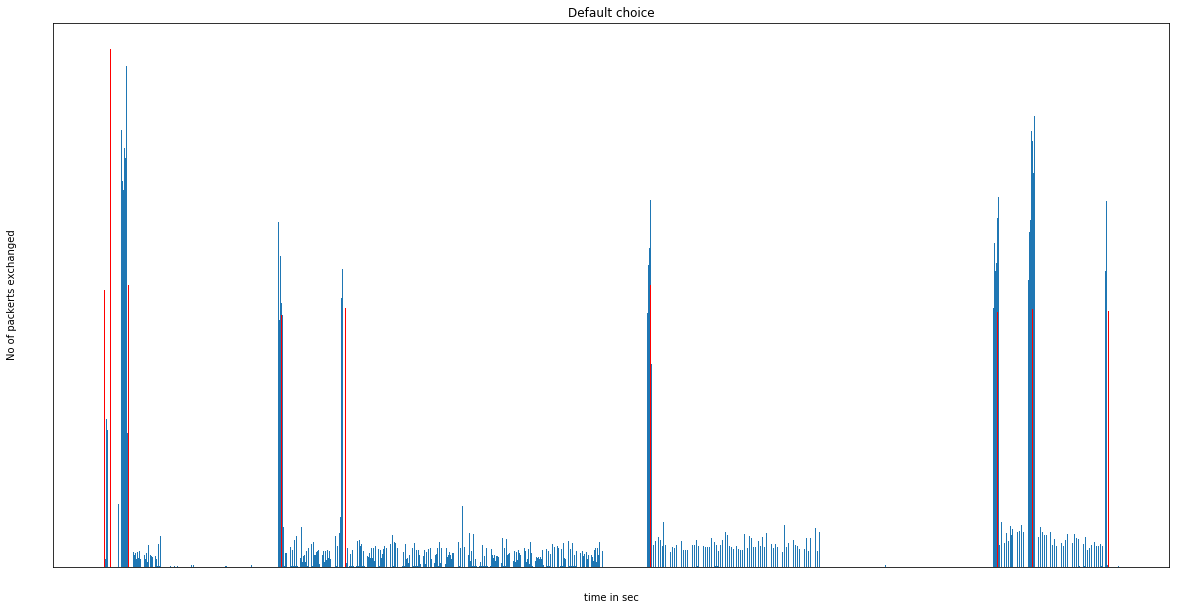

In [31]:
# plot the data-cl2 along with all the pakets
plt.figure(figsize=(20,10))
plt.bar(d_time, pkt_cnt)
plt.bar(cl2_time, cl2_cnt, color = 'red')
plt.ylabel('No of packerts exchanged')
plt.xlabel('time in sec')
plt.title("Default choice")
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')
plt.show()


In [32]:
# [{'time':x, 'frame_no':y } for x, y in zip(d,f_no)]

In [33]:
# filter out all the packets which are not near the peaks
final = []
for i in range(len(cl2_time)):
#     print("processing : {}".format(d[i]))
    for peak in f_peaks:
        if cl2_time[i]>= peak[0] and cl2_time[i]<=peak[-1]+2:
#             print("found in range : {}".format(peak))
            final.append(cl2_time[i])
#         else:
#             print("not found in any range") # debug

In [34]:
# comparing the filtered and non-filtered cl2's
print("using only length filter: {} \nfinal cl2's: {}".format(cl2_time, final))

using only length filter: [3, 8, 25, 164, 222, 500, 816, 848, 917] 
final cl2's: [25, 164, 222, 500, 816, 848, 917]


In [35]:
# getting more details about the cl2's
cl2_cnt = [0]
cl2_time = []
f_no = []
start_time = temp.iloc[0,1]

cl2_time.append(start_time)
i = 0
for _,packet in temp.iterrows():
    f_no.append(packet['No'])
    curr_time = packet.Time
    if curr_time > start_time:
        i += 1
        cl2_cnt.append(0)
        cl2_time.append(curr_time)
        start_time = curr_time
    cl2_cnt[i]+= packet['tls_len']
    
# printing the result
print("cl2 length: {} \ncl2 occurance time: {}".format(cl2_cnt, cl2_time))

In [37]:
ll = [[x,y] for x, y in zip(cl2_time,f_no)]
print(ll)

[[3.435062504, 443], [8.462796786, 10048], [8.682668236, 10121], [25.116945629, 34576], [164.263293638, 44989], [222.59469943099998, 57799], [500.74495569, 80248], [816.3154149610001, 102252], [848.046948384, 118260], [917.531750925, 137040]]


In [38]:
# filtering the cl2's if not near peak
final_cl2 = []
for l in ll:
#     print("processing : {}".format(l))
    for peak in f_peaks:
        if l[0]>= peak[0] and l[0]<=peak[-1]+2:
            final_cl2.append(l)
            
print(final_cl2)

[[25.116945629, 34576], [164.263293638, 44989], [222.59469943099998, 57799], [500.74495569, 80248], [816.3154149610001, 102252], [848.046948384, 118260], [917.531750925, 137040]]
